In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
tqdm.pandas()

In [34]:
df = pd.read_parquet("sigmod_merged.parquet").reset_index(drop=True)
df = df.merge(pd.json_normalize(df.data_characteristics), left_index=True, right_index=True)

0
0


In [35]:
df = df[~df.operator.apply(lambda operator_str: any([x in operator_str for x in ['Materialization', 'Noop']]))]

In [36]:
# handle failures
df['operator_original'] = df.operator
df['operator']= df.operator.apply(lambda operator_str: operator_str.split("= fail:")[0])
scalar_ops = ['Left multiply', 'Row summation' , 'Column summation' , 'Left multiply T' , 'Row summation T', 'Column summation T', 'Right multiply','Right multiply T']
df['operator_type'] = df.operator.apply(lambda operator_str: 'scalar' if operator_str in scalar_ops else operator_str)

In [37]:
from collections import defaultdict
materialized_complexity_dict = defaultdict(lambda: 0)
for dataset, operator, complexity in df[df.model == 'materialized'][['dataset', 'operator', 'complexity']].values:
    materialized_complexity_dict[(dataset, operator)] = complexity

def calc_complexity_ratio(row):
    if row[1] == 'Materialization':
        return None
    val = materialized_complexity_dict[(row[0], row[1])]
    if not val:
        return None
    return  val/ row[2]

df['complexity_ratio'] = df[['dataset', 'operator', 'complexity']].apply(calc_complexity_ratio, axis=1)

In [38]:
baseline_lookup_dict = {(dataset, operator, num_cores): mean_time for (dataset, operator, num_cores, mean_time) in df[((df.model == 'materialized') | (df.model == 'baseline'))][['dataset', 'operator', 'num_cores', 'times_mean']].values}
def calc_speedup(row) -> float:
    if row[1] == 'Materialization':
        return 0.0
    baseline = baseline_lookup_dict[(row[0], row[1], row[2])]
    return baseline / row[3]

df['speedup'] = df[['dataset', 'operator', 'num_cores', 'times_mean']].apply(calc_speedup, axis=1)

In [39]:
df.head()

,dataset,join_x,operator,model,tuple_ratio,feature_ratio,cardinality_T,cardinality_S,complexity,selectivity,...,n_target_matches,join_y,n_S,n_R,Tnonzero,Snonzero,operator_original,operator_type,complexity_ratio,speedup
2,/user/data/generated/n_R=1-r_T=100000-c_T=50-r...,preset,Left multiply,materialized,11.73862,10.0,97666,97667,3715591.0,1.00001,...,65867,outer,1,1,3715591,751621,Left multiply,scalar,1.000000,1.000000
3,/user/data/generated/n_R=1-r_T=100000-c_T=50-r...,preset,Left multiply,factorized,11.73862,10.0,97666,97667,751621.0,1.00001,...,65867,outer,1,1,3715591,751621,Left multiply,scalar,4.943437,3.347921
4,/user/data/generated/n_R=1-r_T=100000-c_T=50-r...,preset,Right multiply,materialized,11.73862,10.0,97666,97667,3715591.0,1.00001,...,65867,outer,1,1,3715591,751621,Right multiply,scalar,1.000000,1.000000
5,/user/data/generated/n_R=1-r_T=100000-c_T=50-r...,preset,Right multiply,factorized,11.73862,10.0,97666,97667,751621.0,1.00001,...,65867,outer,1,1,3715591,751621,Right multiply,scalar,4.943437,6.623966
6,/user/data/generated/n_R=1-r_T=100000-c_T=50-r...,preset,Row summation,materialized,11.73862,10.0,97666,97667,3715591.0,1.00001,...,65867,outer,1,1,3715591,751621,Row summation,scalar,1.000000,1.000000


## Per operator type (Scalar, elementwise & ML) show speedup ratio versus complexity ratio

In [40]:
df = df[df.model == 'factorized'].copy()

In [54]:
df[df.times_mean/df.times_std < 0.2]

,dataset,join_x,operator,model,tuple_ratio,feature_ratio,cardinality_T,cardinality_S,complexity,selectivity,...,n_S,n_R,Tnonzero,Snonzero,operator_original,operator_type,complexity_ratio,speedup,operator_type_int,complexity_ratio_rounded
22613,/user/data/generated/n_R=1-r_T=100000-c_T=50-r...,preset,Left multiply,factorized,11.73862,10.0,97666,97667,751621.0,1.00001,...,1,1,3715591,751621,Left multiply,scalar,4.943437,3.175200,0,5.0
29325,/user/data/generated/n_R=1-r_T=100000-c_T=10-r...,preset,Left multiply T,factorized,5.00000,5.0,100000,120000,360000.0,1.20000,...,1,1,872000,360000,Left multiply T,scalar,2.422222,0.599878,0,2.0
36669,/user/data/generated/n_R=1-r_T=100000-c_T=10-r...,preset,Left multiply T,factorized,1.00000,1.0,100000,200000,500000.0,2.00000,...,1,1,500000,500000,Left multiply T,scalar,1.000000,0.474050,0,1.0
36737,/user/data/generated/n_R=1-r_T=100000-c_T=10-r...,preset,Left multiply T,factorized,45.00450,5.0,100000,102222,156888.0,1.02222,...,1,1,469776,156888,Left multiply T,scalar,2.994340,0.468134,0,3.0
39851,/user/data/generated/n_R=1-r_T=100000-c_T=20-r...,preset,Left multiply,factorized,45.00450,5.0,100000,102222,252888.0,1.02222,...,1,1,878664,252888,Left multiply,scalar,3.474518,0.742063,0,3.0


In [42]:
SCALAR = 0
ELEMENTWISE=1
ML = 2

# TODO split up sum and multiply?
def get_operator_type_int(operator: str) -> int:
    match operator:
        case "KMeans" | "Gaussian" | "Logistic Regression" | "Linear Regression":
            return ML
        case "scalar": 
            return SCALAR
        case _:
            return ELEMENTWISE

def round_complexity_ratio(row):
    n_dec = 0 if row[1] == SCALAR else 1
    return round(row[0], n_dec)


df['operator_type_int'] = df.operator_type.apply(get_operator_type_int)
df['complexity_ratio_rounded'] = df[['complexity_ratio', 'operator_type_int']].apply(round_complexity_ratio, axis=1)

In [48]:
def plot_complexity_speedup(df_, sharey='row'):
    for op_group, group_df in df_.groupby("operator_type_int"):
        # create fig, axs
        rows = len(group_df.operator.unique())//4
        fig, axs = plt.subplots(nrows=rows, ncols=4, sharex='row', sharey=sharey, figsize=(15, 6*rows))
        for ax, (operator, dfsub) in zip(axs.flat, group_df.groupby("operator")):
            sns.lineplot(data=dfsub, x='complexity_ratio_rounded', y='speedup', ax=ax, hue='num_cores')
            ax.set_title(operator)

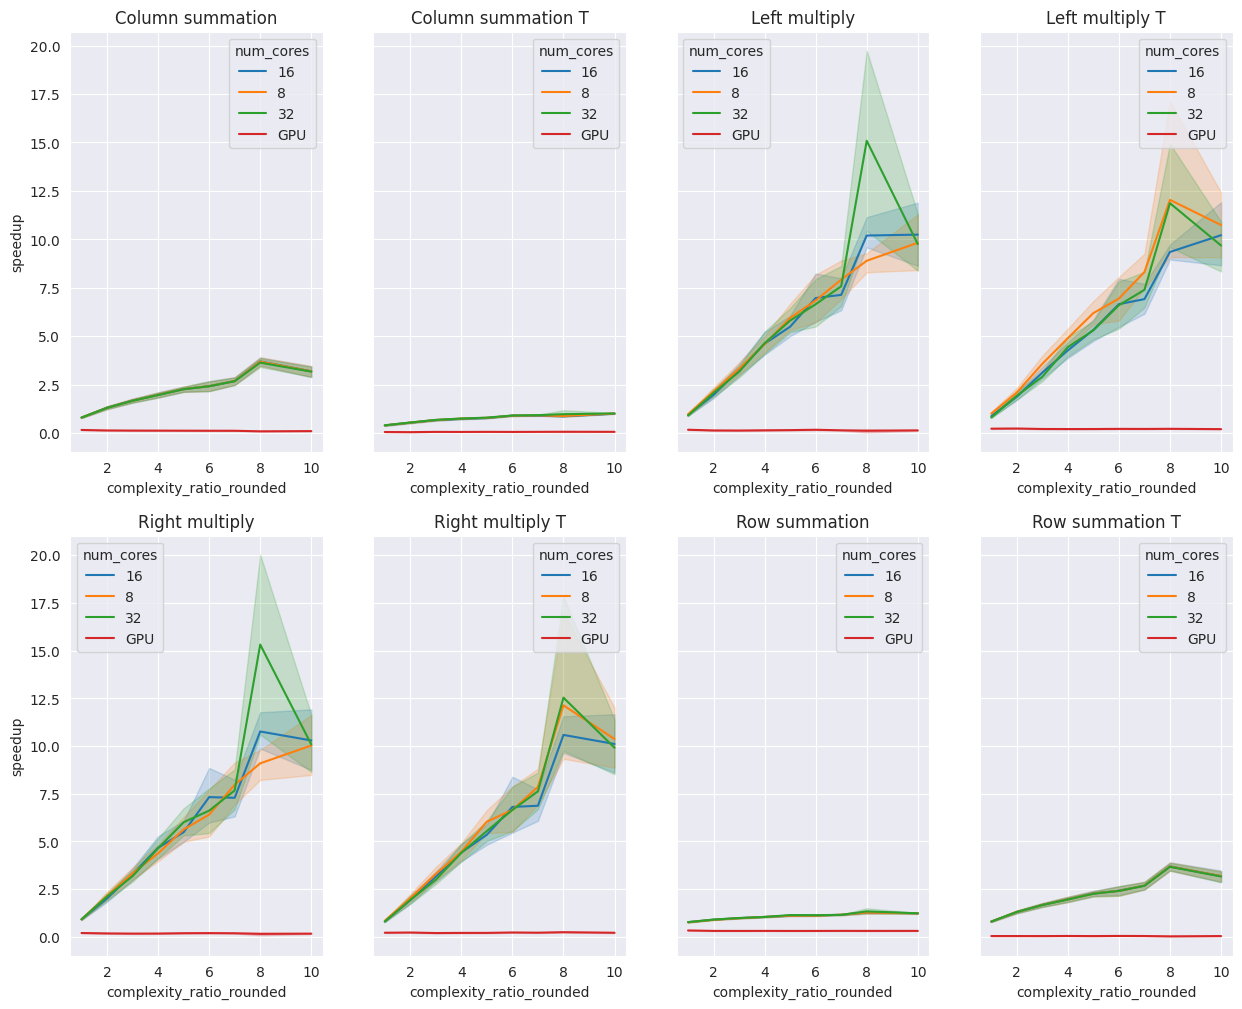

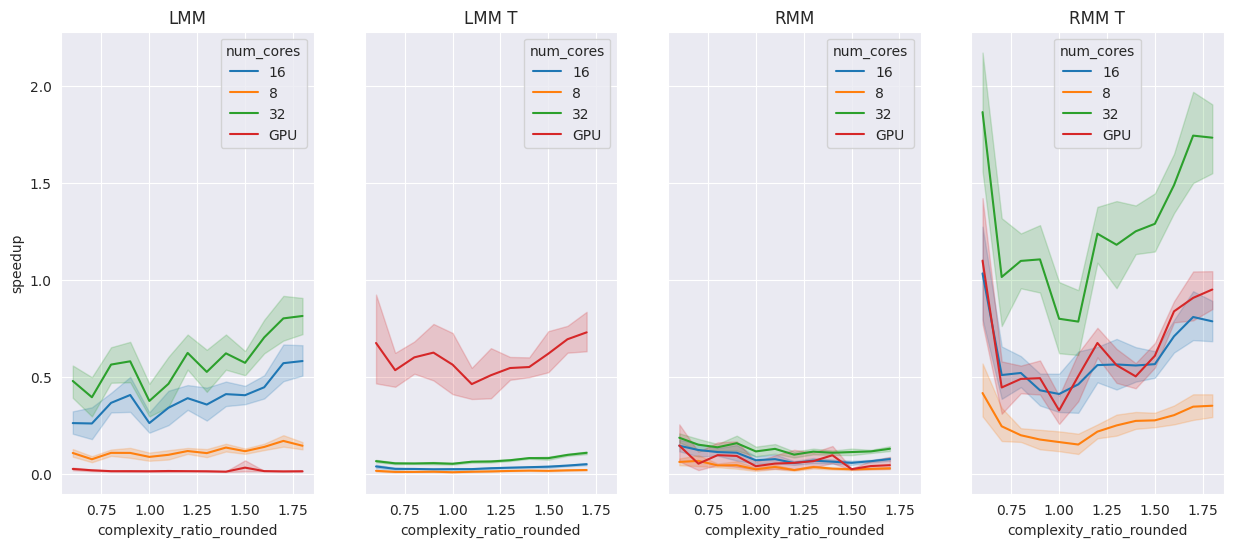

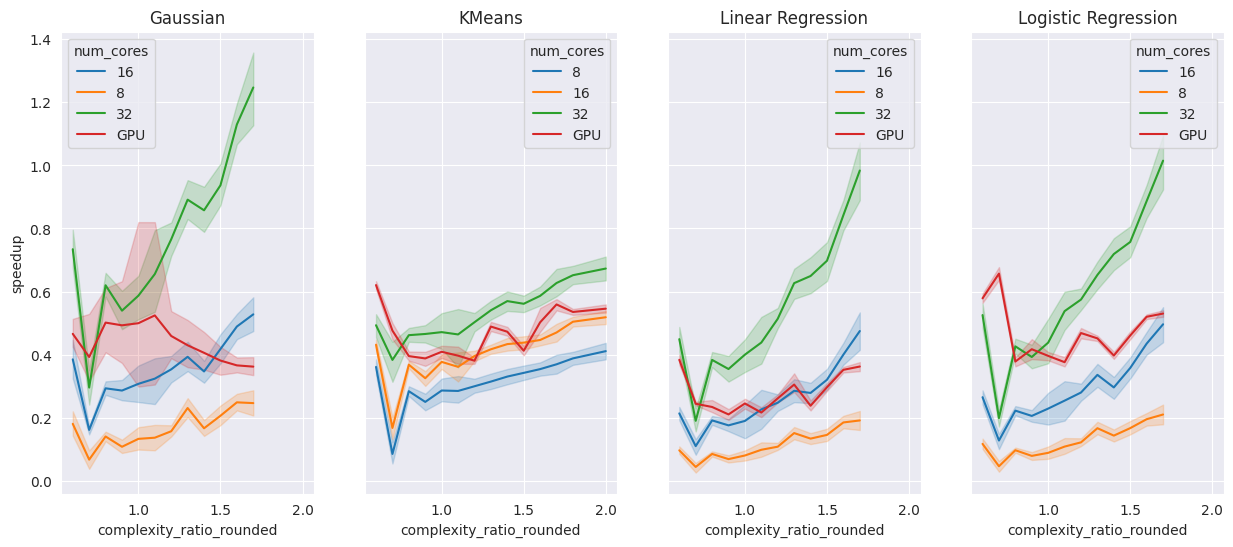

In [49]:
plot_complexity_speedup(df)

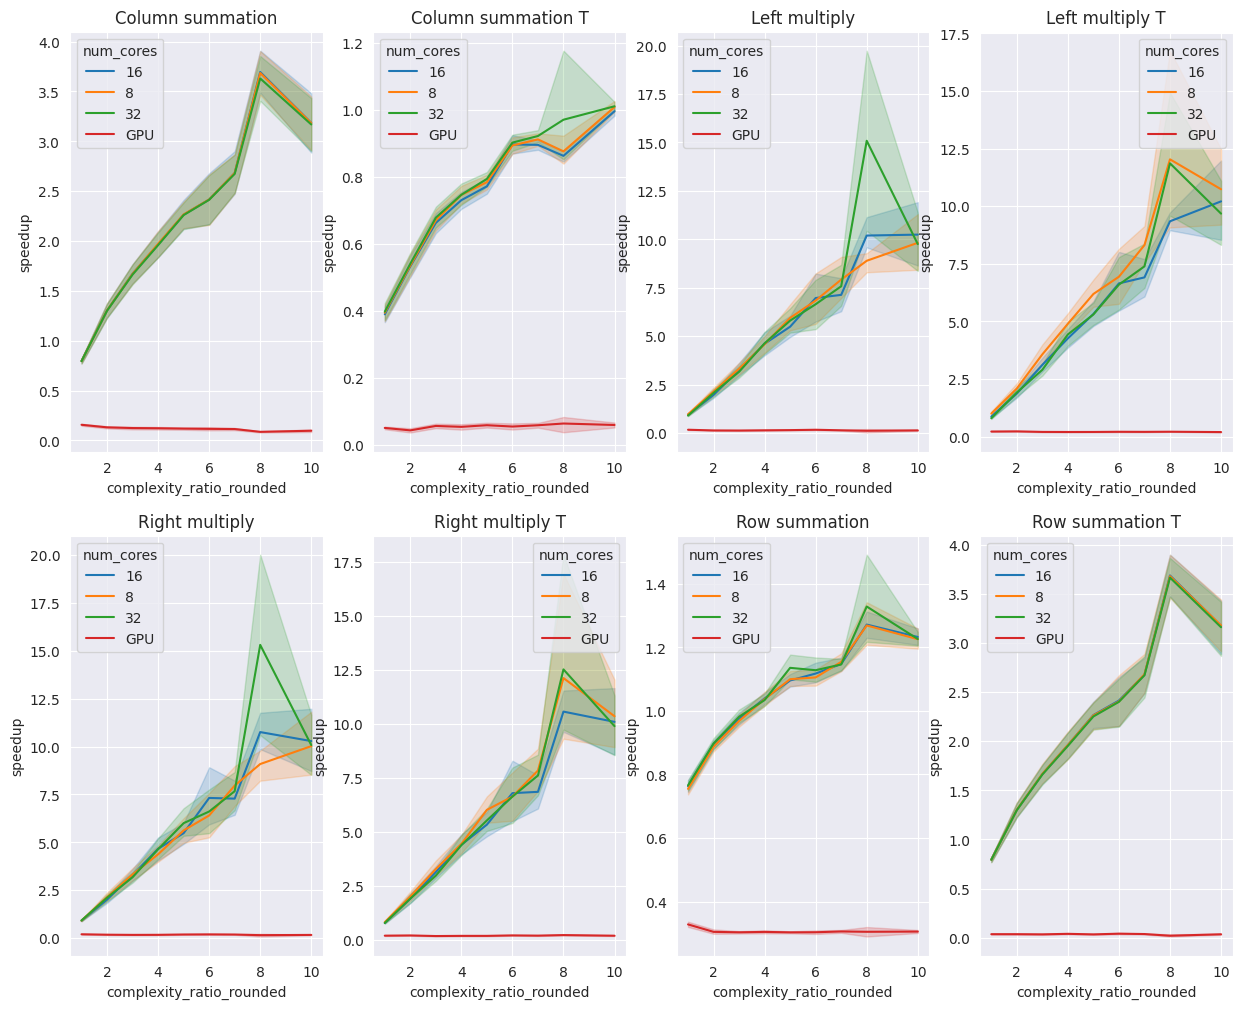

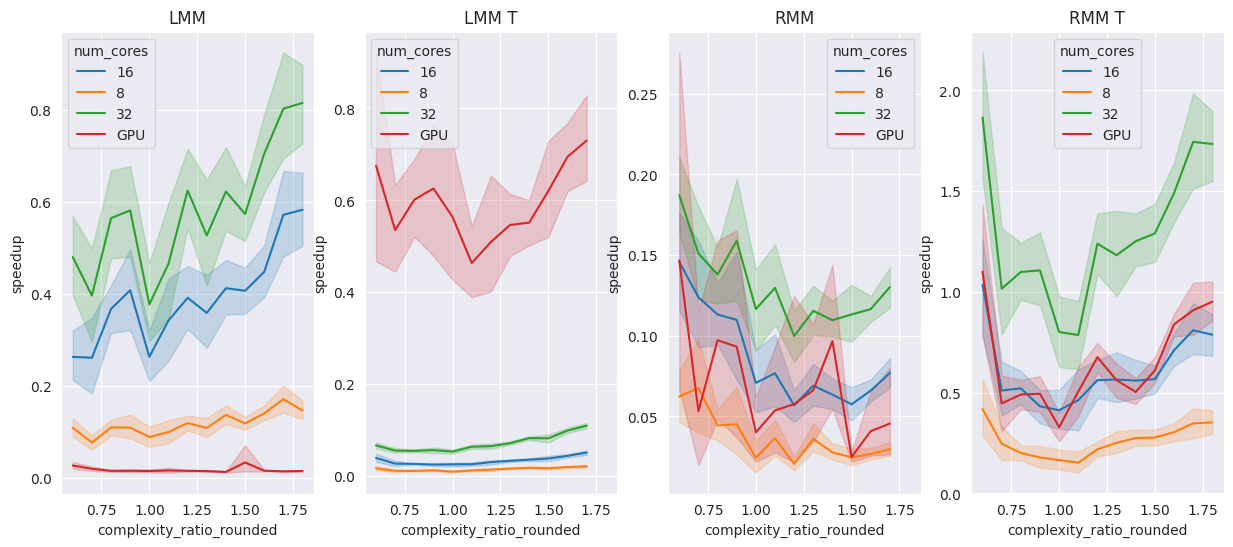

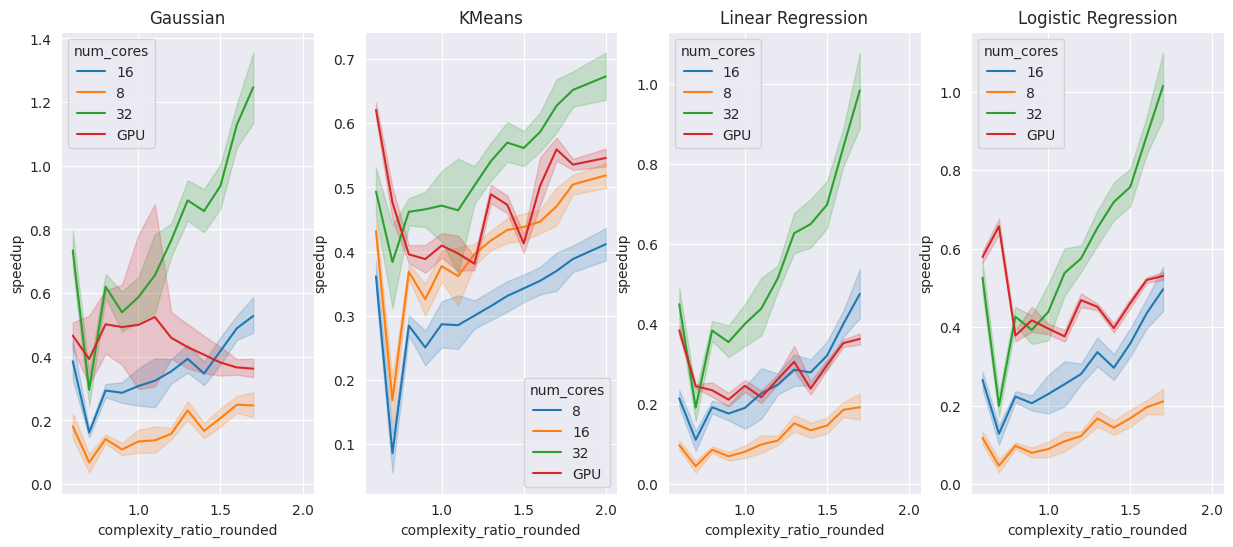

In [50]:
plot_complexity_speedup(df, sharey=False)

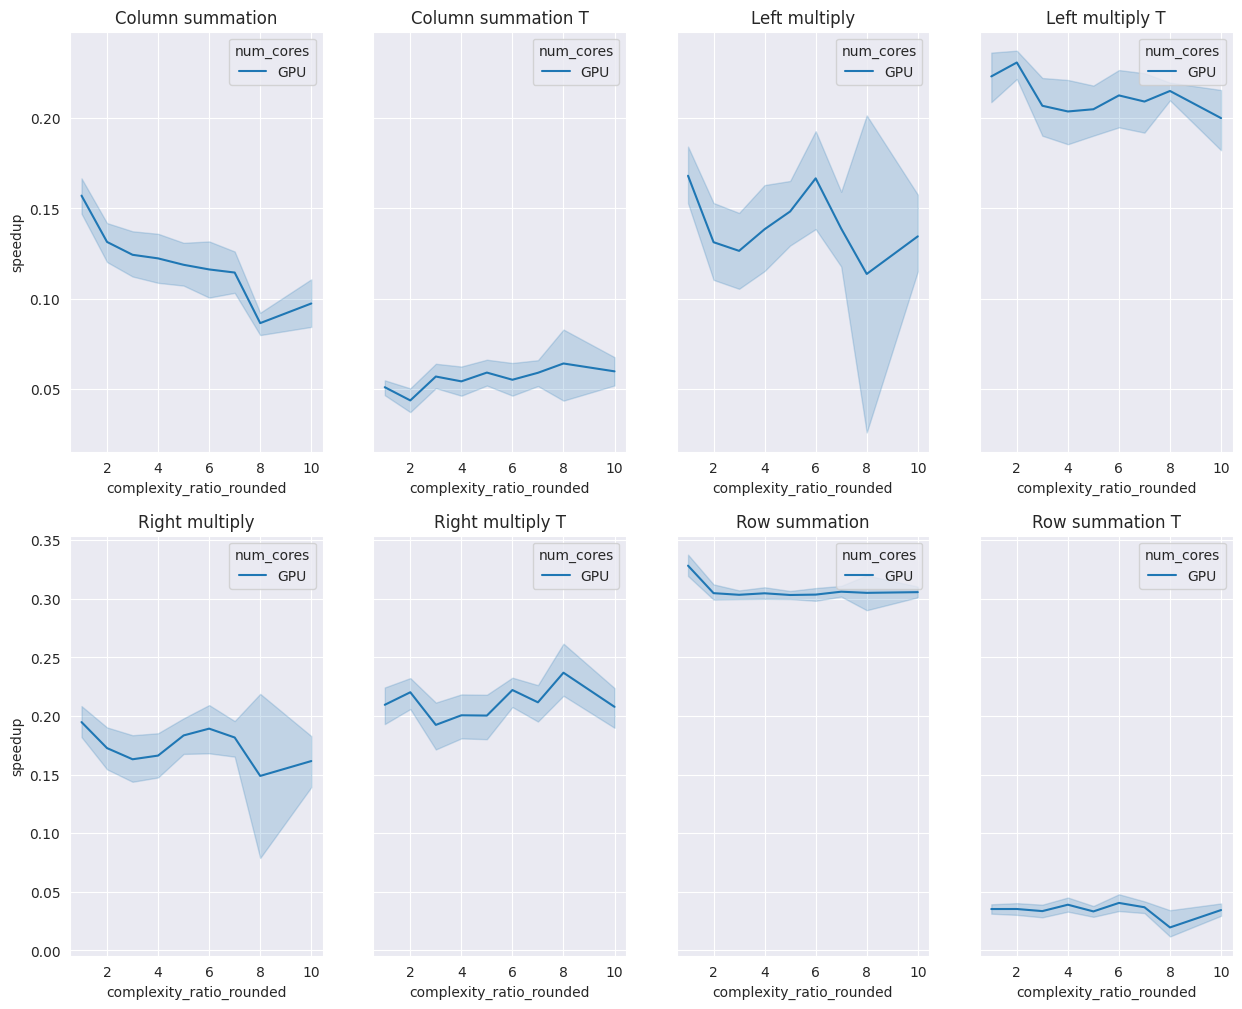

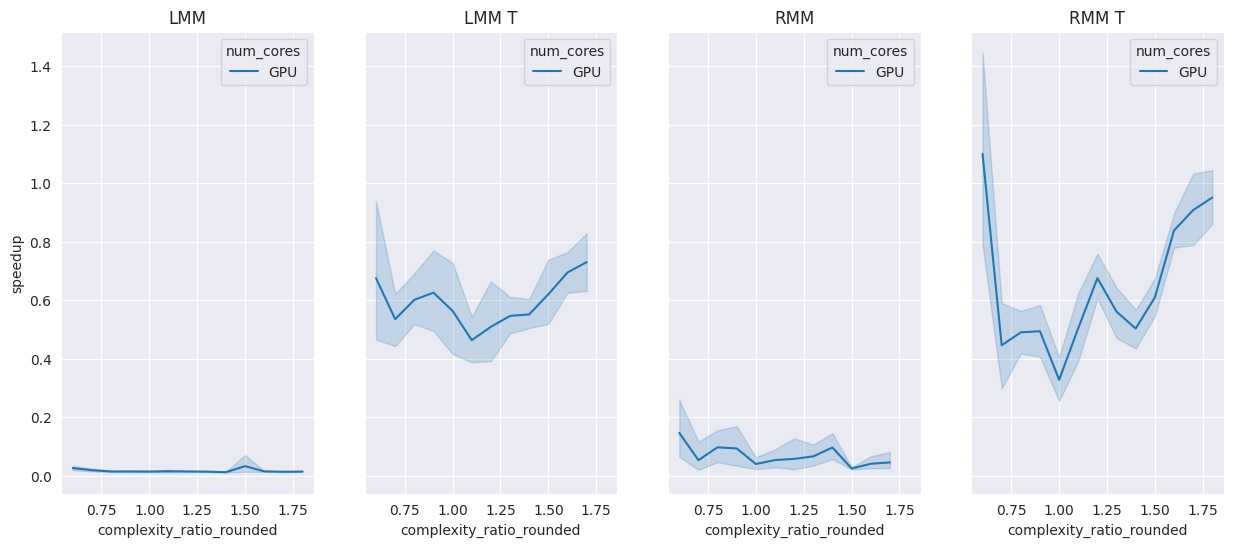

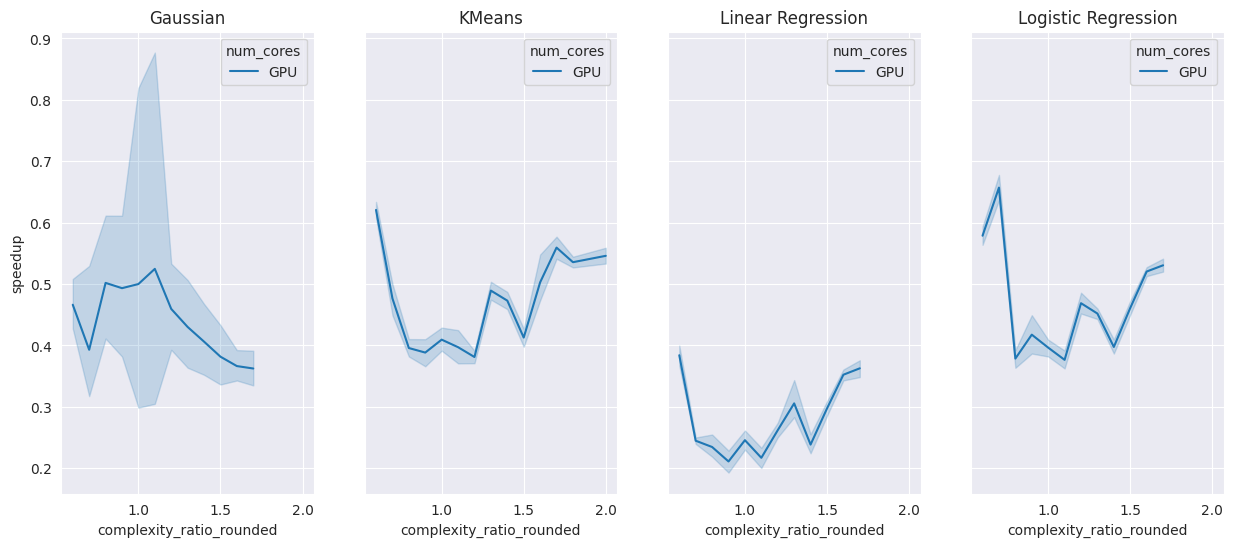

In [45]:
plot_complexity_speedup(df[df.num_cores=='GPU'])